In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import maxent
sns.set_context('paper')
sns.set_style('whitegrid',  {'xtick.bottom':True, 'ytick.left':True, 'xtick.color': '#333333', 'ytick.color': '#333333'})
#plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
colors = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e']
import pynmrstar

2021-08-23 11:57:02.759208: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-9.0/lib64
2021-08-23 11:57:02.759241: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# load data from brmrb
bmrb = pynmrstar.Entry.from_database(20062, convert_data_types=True)
cs_result_sets = []
for chemical_shift_loop in bmrb.get_loops_by_category("Atom_chem_shift"):
     cs_result_sets.append(chemical_shift_loop.get_tag(['Comp_index_ID', 'Comp_ID', 'Atom_ID', 'Atom_type', 'Val', 'Val_err']))
ref_data = pd.DataFrame(cs_result_sets[0], columns=['id', 'res', 'atom', 'type', 'shift', 'error'])

ref_resids = ref_data[ref_data.atom == 'H'].id.values
ref_data[ref_data.atom == 'H'].head(25)

,id,res,atom,type,shift,error
0,1,GLU,H,H,8.131,0.001
6,2,ASN,H,H,8.763,0.001
19,4,VAL,H,H,7.801,0.003
28,5,VAL,H,H,7.584,0.001
37,6,HIS,H,H,8.130,0.004
43,7,PHE,H,H,7.922,0.001
50,8,PHE,H,H,8.286,0.002
57,9,LYS,H,H,8.160,0.001
70,10,ASN,H,H,8.264,0.001
76,11,ILE,H,H,7.735,0.001


In [3]:
HAVE_MD_FILE = False

ref_hdata = ref_data[ref_data.atom == 'H']
# cut GLU because proton type mismatch
ref_hdata = ref_hdata['shift'].values[1:].astype(float)
resnames = ref_data[ref_data.atom == 'H'].res[1:]
if HAVE_MD_FILE:
    data = pd.read_csv('./cs.csv')
    data.head(10)
    # only need weights, so we extract only shifts that will be biased
    hdata_df = data[data.names == 'HN']
    hdata_df = hdata_df[hdata_df['resids'].isin(ref_resids)]
    hdata_c = hdata_df.confident.values.reshape(len(data.frame.unique()), -1)
    hdata = hdata_df.peaks.values.reshape(len(data.frame.unique()), -1)
    assert hdata.shape[-1] == ref_hdata.shape[0]
    np.savez('mbp_files/mbp_cs.npz', hdata=hdata, hdata_c=hdata_c)
data = np.load('mbp_files/mbp_cs.npz')
hdata, hdata_c = data['hdata'], data['hdata_c']

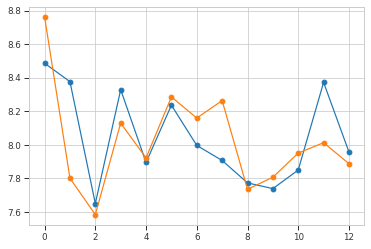

In [4]:
plt.plot(np.mean(hdata, axis=0), 'o-')
plt.plot(ref_hdata, 'o-')
plt.show()

In [5]:
# fill in unconfident peaks with mean
hdata_m = np.sum(hdata * hdata_c, axis=0) / np.sum(hdata_c, axis=0)
total_fill = 0
for i in range(hdata.shape[1]):
    hdata[:,i][~hdata_c[:,i]] = hdata_m[i]
    total_fill += np.sum(~hdata_c[:,i])
print('Filled', total_fill)

Filled 0


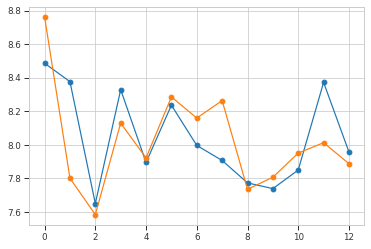

In [6]:
plt.plot(np.mean(hdata, axis=0), 'o-')
plt.plot(ref_hdata, 'o-')
plt.show()

In [7]:
# make restraints
restraints = []
do_restrain = range(len(ref_hdata) // 2)
for i in do_restrain:
    restraints.append(maxent.Restraint(lambda h,i=i: h[i], ref_hdata[i], prior=maxent.Laplace(0.05)))

In [8]:
model = maxent.MaxentModel(restraints)
model.compile(tf.keras.optimizers.Adam(0.1), 'mean_squared_error')
history = model.fit(hdata,epochs=500, verbose=0)

2021-08-23 11:57:05.668014: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-08-23 11:57:05.702730: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce GTX 980 computeCapability: 5.2
coreClock: 1.2785GHz coreCount: 16 deviceMemorySize: 3.95GiB deviceMemoryBandwidth: 208.91GiB/s
2021-08-23 11:57:05.702931: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-9.0/lib64
2021-08-23 11:57:05.703059: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-9.0/lib64
2021-08-23 11:57:05.703171: W ten

1.2122026574526695e-14


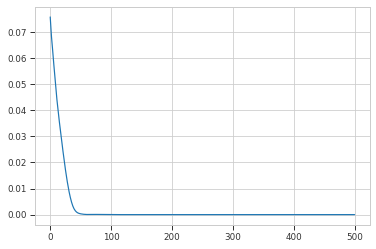

In [9]:
plt.plot(history.history['loss'])
print(history.history['loss'][-1])

In [10]:
np.mean(np.abs(np.sum(hdata * model.traj_weights[...,np.newaxis], axis=0) - ref_hdata))

0.12929262748131382

In [11]:
model.lambdas

<tf.Variable 'maxent-lambda:0' shape=(6,) dtype=float32, numpy=
array([-3.4798522 ,  4.554573  ,  0.15842082,  1.4714803 , -0.7225199 ,
        0.8692107 ], dtype=float32)>

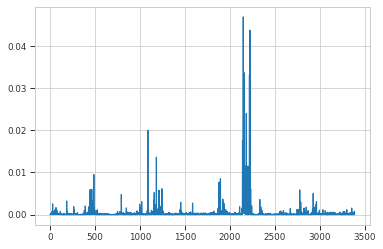

In [12]:
plt.plot(model.traj_weights)

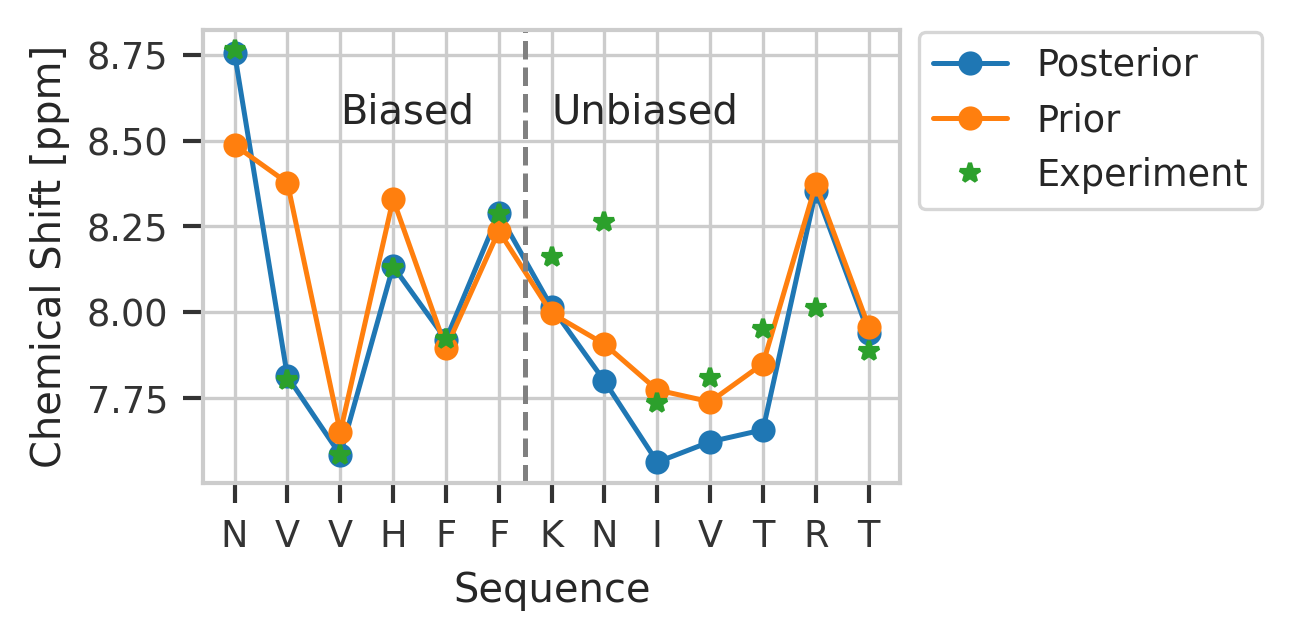

In [18]:
plt.figure(figsize=(3,2), dpi=300)
seq_dict = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
 'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N', 
 'GLY': 'G', 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W', 
 'ALA': 'A', 'VAL':'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M'}
plt.plot(np.sum(hdata * model.traj_weights[...,np.newaxis], axis=0), 'o-', label='Posterior')
plt.plot(np.mean(hdata, axis=0), 'o-', label='Prior')
plt.plot(ref_hdata, '*', label='Experiment')
plt.axvline(x=len(ref_hdata) // 2 - 0.5, color='gray', linestyle='--')
plt.xticks(range(len(ref_hdata)), [seq_dict[r] for r in resnames])
plt.legend(loc="center left", bbox_to_anchor=(1.0, 0.8))
plt.text(len(ref_hdata) // 5, 8.55, 'Biased')
plt.text(len(ref_hdata) // 2, 8.55, 'Unbiased')
plt.xlabel('Sequence')
plt.ylabel('Chemical Shift [ppm]')
plt.savefig('protein.pdf')

In [14]:
print('most favored clusters', np.argsort(model.traj_weights)[-3:])

most favored clusters [2158 2221 2147]
